**[readme](file/README.md)**

In [379]:
#Readme file assumed to be in current working directory

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Loading and Merging Data

In [217]:
merged = pd.read_csv('./Merged Data/GRADUATION_WITH_CENSUS.csv', encoding = "ISO-8859-1")

In [218]:
#Loading data
df1 = pd.read_csv('./School_District_Finances/SS1300A15.dat', delimiter='|')
df2 = pd.read_csv('./School_District_Finances/SS1300A16.dat', delimiter='|')
df3 = pd.read_csv('./School_District_Finances/SS1300A17.dat', delimiter='|')
df4 = pd.read_csv('./School_District_Finances/SS1300A18.dat', delimiter='|')
merged = pd.read_csv('./Merged Data/GRADUATION_WITH_CENSUS.csv', encoding = "ISO-8859-1")

In [219]:
#transforming GEO_ID to leaid11
for frame in [df1, df2, df3, df4]:
    frame['leaid11'] = frame['GEO_ID'].map(lambda x: int(x[-7:]))
    frame.drop('GEO_ID', axis=1, inplace=True)

In [220]:
#Merging dataframes
df = df1.merge(df2, on='leaid11')
df = df.merge(df3, on='leaid11')
df = df.merge(df4, on='leaid11')

main_df = merged.merge(df, on='leaid11')

### Removing Missing Data

In [221]:
main_df.isnull().sum().sort_values(ascending=False).head(20)

SCHEXPCSSSA_PP_F    9881
SCHSDEXPOPG_F       9881
SCHEXPCSSSA_F       9881
SCHREVSSGFA_F       9881
SCHSDEXPCSSON_F     9881
SCHREVSS_F          9881
SCHEXPCSOF_F        9881
SCHSDREVFSDSON_F    9881
SCHEXPCO_F          9881
SCHREVFSDSCN_F      9881
SCHREVFSDSSE_F      9881
SCHEXPCSSGA_F       9881
SCHEXPOID_F         9881
SCHREVFSDSTIT_F     9881
SCHREVFS_F          9881
FOOTID_GEO_x        9881
SCHSDTOTREV_F       9881
SCHENROLL_F_x       9881
SCHENROLL_F_x       9881
FOOTID_GEO_x        9881
dtype: int64

In [222]:
#Through review of the data dictionary and google searching the competition during which this datasets was released,
#I was unable to definitively conclude a logical way to impute nulls in this dataset. I think the safest approach
#would be to impute the median, but for now I will drop all nulls to avoid making assumptions.

#Checking for nulls. Some features contain sufficient nulls such that they should be dropped.
#After studying null values, I have decided to drop columns with nulls exceeding 2650
cols = list(main_df.isnull().sum().sort_values(ascending=False)[(main_df.isnull().sum().sort_values(ascending=False) >= 2650).values].index)
main_df.drop(cols, axis=1, inplace=True)

In [223]:
#A few columns contain remaining nulls
main_df.isnull().sum().sort_values(ascending=False).head(10)

CWD_COHORT_1112                     344
CWD_RATE_1112                       344
Mail_Return_Rate_CEN_2010           236
pct_BILQ_Mailout_count_CEN_2010     229
pct_Census_Mail_Returns_CEN_2010    229
pct_TEA_Update_Leave_CEN_2010       229
pct_TEA_MailOutMailBack_CEN_2010    229
pct_Vacant_CEN_2010                 229
pct_Deletes_CEN_2010                229
pct_Census_UAA_CEN_2010             229
dtype: int64

In [224]:
#Drop rows with remaining nulls
main_df.dropna(inplace=True)

In [225]:
#Confirm no remaining nulls
main_df.isnull().sum().sum()

0

### Duplicate Columns

In [226]:
#Duplicate columns resulted from merging. Will need to identify and drop duplicates.
main_df[['GEO_TTL_x', 'GEO_TTL_y']].head()

,GEO_TTL_x,GEO_TTL_x,GEO_TTL_y,GEO_TTL_y
0,"Albertville City School District, Alabama","Albertville City School District, Alabama","Albertville City School District, Alabama","Albertville City School District, Alabama"
1,"Marshall County School District, Alabama","Marshall County School District, Alabama","Marshall County School District, Alabama","Marshall County School District, Alabama"
2,"Hoover City School District, Alabama","Hoover City School District, Alabama","Hoover City School District, Alabama","Hoover City School District, Alabama"
3,"Madison City School District, Alabama","Madison City School District, Alabama","Madison City School District, Alabama","Madison City School District, Alabama"
4,"Leeds City School District, Alabama","Leeds City School District, Alabama","Leeds City School District, Alabama","Leeds City School District, Alabama"


In [227]:
#Looking for duplicate columns

#Creates dictionary with key column name and value count of occurences
column_counts = {}
for col in main_df.columns:
    if col in column_counts:
        column_counts[col] += 1
    else:
        column_counts[col] = 1

#Prints columns that have more than one occurrence. We have no more than two occurrences of a column
dupes = []
for key, value in column_counts.items():
    if value > 1:
        print(key, value)
        dupes.append(key)

GEOTYPE_x 2
ST_x 2
GEO_TTL_x 2
YEAR_x 2
SCHENROLL_x 2
GEOTYPE_y 2
ST_y 2
GEO_TTL_y 2
YEAR_y 2
SCHENROLL_y 2


In [228]:
#If I drop the column by name it will drop both columns which is not desired
print(main_df.shape)
print(main_df.drop('GEOTYPE_x', axis=1).shape)

list(main_df.columns).index("GEOTYPE_x")

to_drop = []
#Gets column numbers from names for removing via iloc
for key, value in column_counts.items():
    if value > 1:
        to_drop.append(list(main_df.columns).index(key))
        
to_drop

(8922, 644)
(8922, 642)


[568, 569, 570, 571, 572, 592, 593, 594, 595, 596]

In [229]:
#Generating list of columns indexes excluding the ones corresponding to duplicates
kept_indexes = list(range(main_df.columns.shape[0]))
print(len(kept_indexes) - len(to_drop))
for i in range(len(to_drop)):
    kept_indexes.remove(to_drop[i])

#Kept indexes is now a list of numbers for column indexes to be kept. Confirm length matches expected result.
len(kept_indexes)

634


634

In [230]:
#Duplicate columns removed
main_df = main_df.iloc[:,kept_indexes]

In [231]:
#Columns with _x, _y are also duplicates. Dropping one of each
main_df.columns

Index(['Unnamed: 0', 'leaid11', 'STNAM', 'FIPST', 'leanm11', 'ALL_COHORT_1112',
       'ALL_RATE_1112', 'MWH_COHORT_1112', 'MWH_RATE_1112', 'CWD_COHORT_1112',
       ...
       'SCHEXPCSFSW_PP', 'SCHEXPCSFEB_PP', 'SCHEXPCSIT_PP', 'SCHEXPCSISW_PP',
       'SCHEXPCSIEB_PP', 'SCHEXPCSST_PP', 'SCHEXPCSSPS_PP', 'SCHEXPCSSIS_PP',
       'SCHEXPCSSGA_PP', 'SCHEXPCSSSA_PP'],
      dtype='object', length=634)

In [232]:
#Example duplicates
main_df[['ST_x', 'ST_y']].describe()

,ST_x,ST_y
count,8922.000000,8922.000000
mean,30.831876,30.831876
std,14.666596,14.666596
min,1.000000,1.000000
25%,19.000000,19.000000
50%,31.000000,31.000000
75%,42.000000,42.000000
max,56.000000,56.000000


In [233]:
#Example duplicates
main_df[['GEO_TTL_y', 'GEO_TTL_x']].head()

,GEO_TTL_y,GEO_TTL_x
0,"Albertville City School District, Alabama","Albertville City School District, Alabama"
1,"Marshall County School District, Alabama","Marshall County School District, Alabama"
2,"Hoover City School District, Alabama","Hoover City School District, Alabama"
3,"Madison City School District, Alabama","Madison City School District, Alabama"
4,"Leeds City School District, Alabama","Leeds City School District, Alabama"


In [234]:
#Find all column names ending in '_y'
redundant_features = [col for col in main_df.columns if col[-2:] == '_y']
print(redundant_features)

#Drop redundant features
main_df.drop(redundant_features, axis=1, inplace=True)

['GEOTYPE_y', 'ST_y', 'GEO_TTL_y', 'YEAR_y', 'SCHENROLL_y']


In [235]:
#Unnamed 0 is another index. Dropping this feature
main_df.drop('Unnamed: 0', axis=1, inplace=True)

In [236]:
#Dropping all ACSMOE features as they are all margins of error of other features, not independently meaningful themselves
moe_features = [feature for feature in main_df.columns if 'ACSMOE' in feature]
print(moe_features[:5])
main_df.drop(moe_features, axis=1, inplace=True)

['Tot_Population_ACSMOE_08_12', 'Males_ACSMOE_08_12', 'Females_ACSMOE_08_12', 'Pop_under_5_ACSMOE_08_12', 'Pop_5_17_ACSMOE_08_12']


### Feature Exploration

In [237]:
#Checking datatypes
main_df.dtypes.head(20)

leaid11              int64
STNAM               object
FIPST                int64
leanm11             object
ALL_COHORT_1112      int64
ALL_RATE_1112      float64
MWH_COHORT_1112    float64
MWH_RATE_1112       object
CWD_COHORT_1112    float64
CWD_RATE_1112       object
ECD_COHORT_1112    float64
ECD_RATE_1112       object
Percentage         float64
State                int64
County               int64
Tract.Code           int64
School.District     object
District.ID          int64
GIDTR                int64
State.1              int64
dtype: object

In [238]:
#Several rate features are type object, but should be float. Checking values for MWH_RATE_1112
print(main_df['MWH_RATE_1112'].unique())

#Some values are ranges, others are LE(<=)/GE(>=)/LT(<)/GT(>)/PS(not provided)
#I will take the mean of ranges
#LE/LT and GE/GT will be approximated by the middle number between lower bound and upper bound
#PS, LT, GT columns will be dropped since the information is too vague

def convert_rates(range_nums):
    if range_nums.isdigit():
        return float(range_nums)
    elif '-' in range_nums:
        first_num = float(range_nums[:range_nums.index('-')])
        second_num = float(range_nums[range_nums.index('-')+1:])
        return (first_num + second_num)/2
    
    elif ('GE' in range_nums) or ('GT' in range_nums):
        num = float(range_nums[2:])
        return (100 + num)/2
    
    elif ('LE' in range_nums) or ('LT' in range_nums):
        num = float(range_nums[2:])
        return num / 2
    else:
        return float('nan')

['85-89' '79' '94' '93' '75-79' '90-94' '80-84' 'PS' '60-64' '82' '77'
 'LT50' 'LE20' '84' 'GE90' '70-74' '78' '70-79' '65-69' '40-59' '80-89'
 '80' '60-69' '90' 'GE95' '88' '85' '86' '87' '74' '50-54' '91' 'GE50'
 '98' '60-79' '21-39' 'GE80' '81' '92' '83' '76' '64' '89' '96' '75' '97'
 '95' '71' '65' '30-39' '30-34' '72' '55-59' '68' '50-59' '23' '45-49'
 '20-29' '70' '40-49' 'GE99' '73' '67' '62' '69' '63' '35-39' '56' '51'
 '25-29' '15-19' '40-44' '36' '49' '58' '61' '59' '66']


In [239]:
num_ps = main_df['MWH_RATE_1112'].value_counts()['PS']
print('Convert rates should result in {} nans when mapped to MWH_RATE_1112'.format(num_ps))

#Confirm function is working properly
print(main_df['MWH_RATE_1112'].map(convert_rates).isnull().sum(), 'nans created')

Convert rates should result in 164 nans when mapped to MWH_RATE_1112
164 nans created


In [240]:
#Applying numeric transformation with the following rate features:
#MWH_RATE_1112, CWD_RATE_1112, ECD_RATE_1112

main_df['MWH_RATE_1112'] = main_df['MWH_RATE_1112'].map(convert_rates)
main_df['CWD_RATE_1112'] = main_df['CWD_RATE_1112'].map(convert_rates)
main_df['ECD_RATE_1112'] = main_df['ECD_RATE_1112'].map(convert_rates)

#Drop nans that replaced PS in rate features
main_df.dropna(inplace=True)

In [243]:
#Two price features contain dollar signs and commas: Med_House_value_ACS_08_12, Med_HHD_Inc_ACS_08_12
def clean_money(money):
    comma_index = money.index(',')
    return int(money[1:comma_index] + money[comma_index+1:])

main_df['Med_House_value_ACS_08_12'] = main_df["Med_House_value_ACS_08_12"].map(clean_money)
main_df['Med_HHD_Inc_ACS_08_12'] = main_df["Med_HHD_Inc_ACS_08_12"].map(clean_money)

In [246]:
#Some values in the correlation matrix are nans. This indicates features that do not vary. Dropping those features as they do not provide any information

#Example
print(main_df['YEAR_x'].unique())

main_df.corr().isnull().sum().sort_values(ascending=False).head()

[2013]


GEOTYPE_x                    397
YEAR_x                       397
SCHEXPCSSSA_PP                 2
Diff_HU_1yr_Ago_ACS_08_12      2
Born_foreign_ACS_08_12         2
dtype: int64

In [247]:
main_df.drop(['YEAR_x', 'GEOTYPE_x'], axis=1, inplace=True)

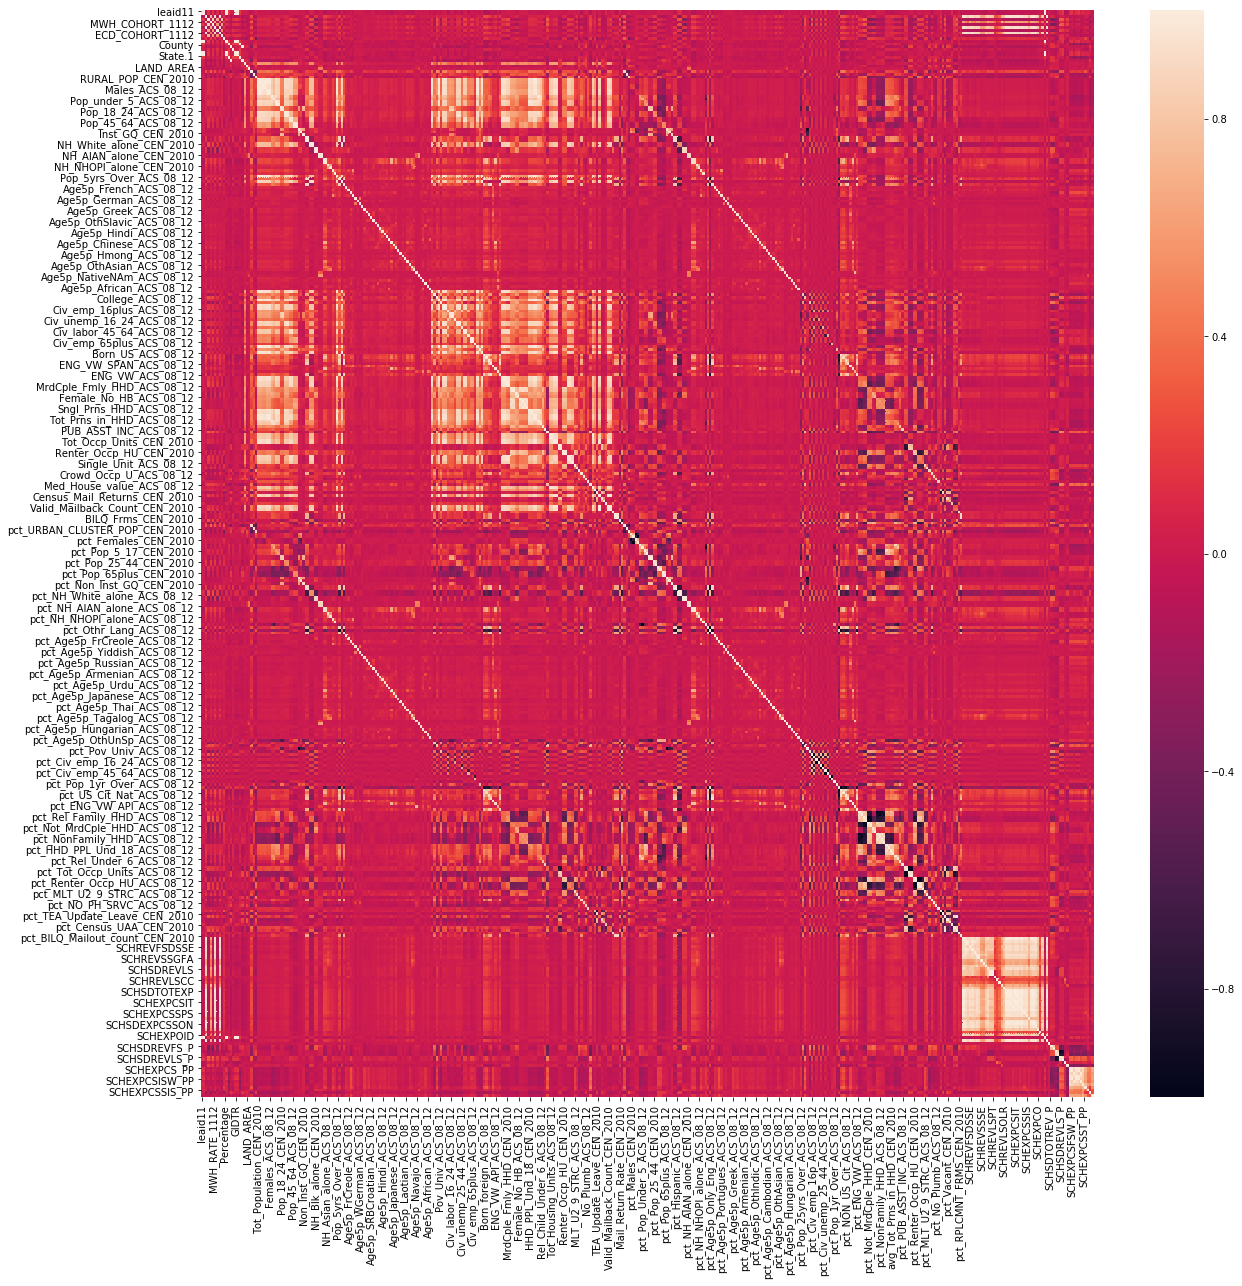

In [248]:
#Far too many features. Should sort correlation matrix by absolute value of ALL_RATE_1112 correlations and heatmap these only
plt.figure(figsize=(20, 20))
sns.heatmap(main_df.corr())

In [249]:
#Renaming some features for clarity
main_df = main_df.rename(columns={
    "SCHSDREVFSDSTIT_P": "fed_titleI_rev_p",
    "SCHSDREVFS_P": "fed_rev_tot_p",
    "SCHSDREVLS_P": "local_rev_tot_p",
    "SCHSDREVLSTPGC_P": "local_rev_taxandpgovt_p",
    "SCHSDREVSS_P": "state_rev_tot_p",
    "SCHSDREVLSC_P": "local_rev_charges_p",
    "SCHREVFS": "fed_rev_tot",
    "SCHSDREVSSGFA_P": "state_rev_gen-formula-assistance_p",
    "SCHREVSS": "state_rev_tot",
    "SCHREVFSDSCN": "fed_rev_child-nutrition",
    "SCHSDREVFSDSON": "fed_rev_other",
    "SCHEXPCSOF": "tot_spending_other",
    "SCHREVFSDSTIT": "fed_titleI_rev",
    "SCHEXPCSSIS": "tot_spending_instr_staff_support",
    "SCHSDREVLS": "local_revenue_total",
    "SCHEXPCO": "expenditure_capital-outlay",
    "SCHEXPCSFEB_PP": "employee_benefits_spending"
})

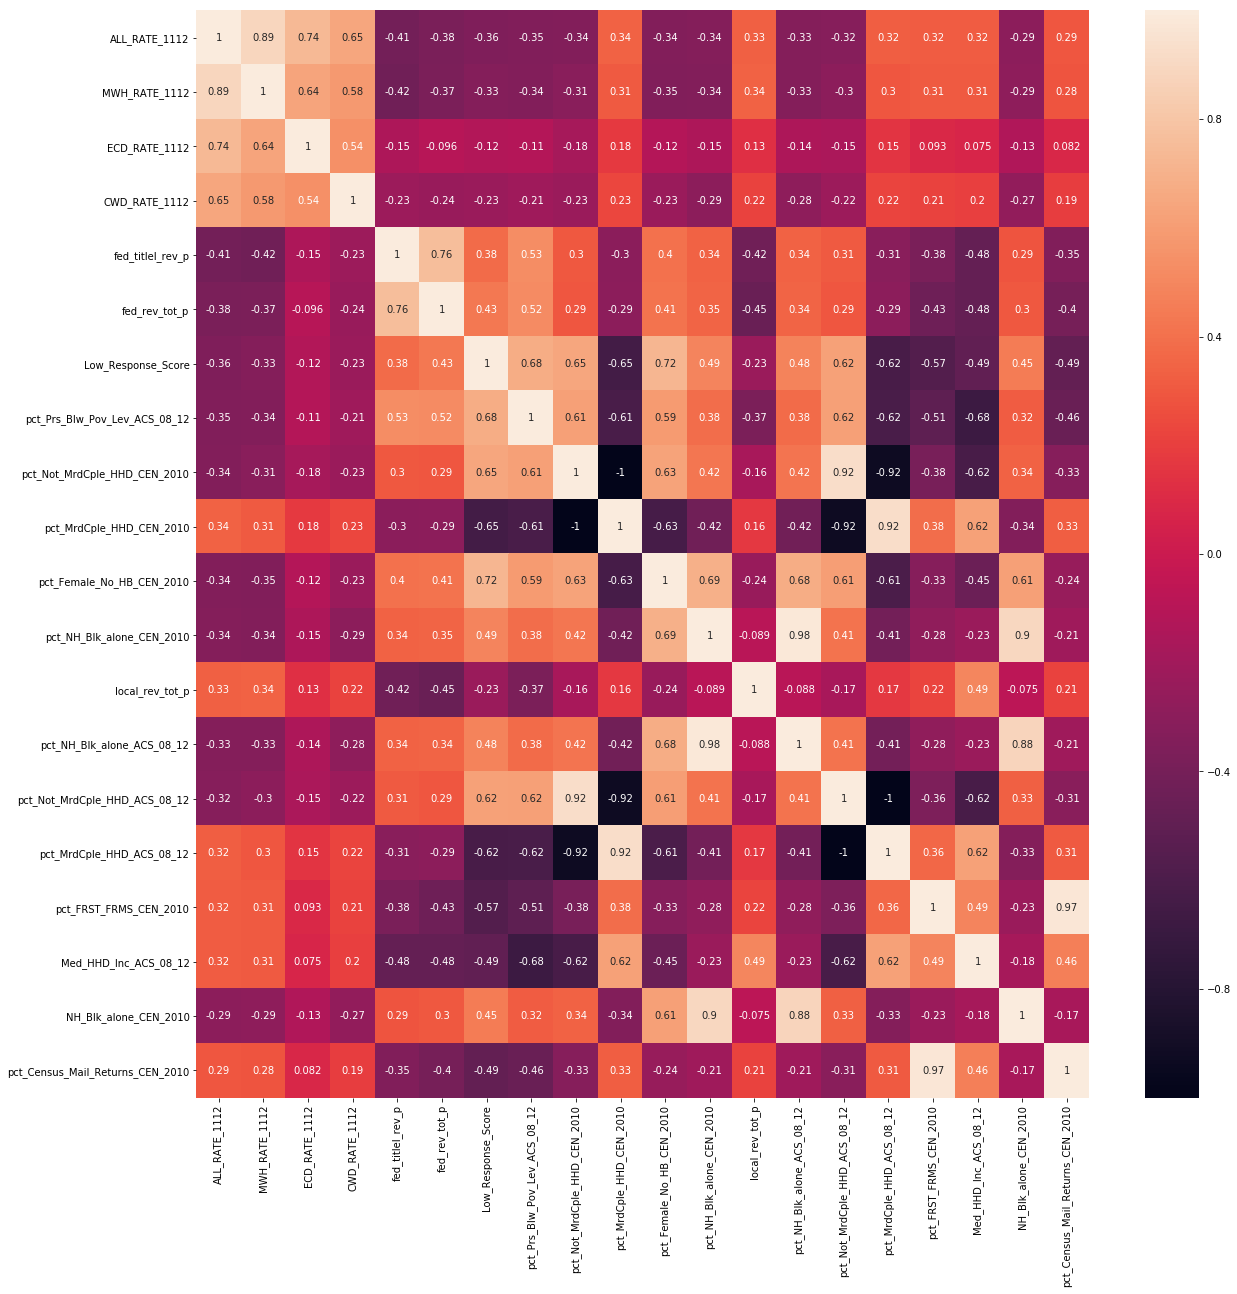

In [250]:
#top 20 correlations with ALL_RATE_1112
top_corr_features = abs(main_df.corr()['ALL_RATE_1112']).sort_values(ascending=False).head(20).index

#Heatmap of only top 20 correlated features
plt.figure(figsize=(20,20))
sns.heatmap(main_df[top_corr_features].corr(), annot=True)

In [251]:
#From the heatmap generated above, it appears graduation rates most strongly correlate with graduation rates of 
#white students, economically disadvantaged students, and students with disabilities

#It makes sense that a higher percentage of graduating students in a particular group would correspond with 
#higher graduation rates overall, but perhaps the difference in correlations between the three groups is 
#instructive

#Also worth noting, the number of economically disadvantaged and disabled students in a graduating cohort
#negatively correlate with graduation rate

print('all students:\n', main_df['ALL_RATE_1112'].describe(), '\n')
print('white students:\n', main_df['MWH_RATE_1112'].describe(), '\n')
print('economically disadvantaged students:\n', main_df['ECD_RATE_1112'].describe(), '\n')
print('students with disabilities:\n', main_df['CWD_RATE_1112'].describe())

all students:
 count    6874.000000
mean       85.494690
std         9.127833
min        18.000000
25%        82.000000
50%        87.000000
75%        92.000000
max        99.000000
Name: ALL_RATE_1112, dtype: float64 

white students:
 count    6874.000000
mean       87.105324
std         9.609434
min        10.000000
25%        82.000000
50%        90.000000
75%        93.000000
max        99.500000
Name: MWH_RATE_1112, dtype: float64 

economically disadvantaged students:
 count    6874.000000
mean       78.613835
std        11.925304
min         7.500000
25%        72.000000
50%        78.000000
75%        90.000000
max        97.500000
Name: ECD_RATE_1112, dtype: float64 

students with disabilities:
 count    6874.000000
mean       68.203957
std        17.555089
min         5.000000
25%        62.250000
50%        75.000000
75%        75.000000
max        97.500000
Name: CWD_RATE_1112, dtype: float64


Text(0.5,1,'students w/disabilities')

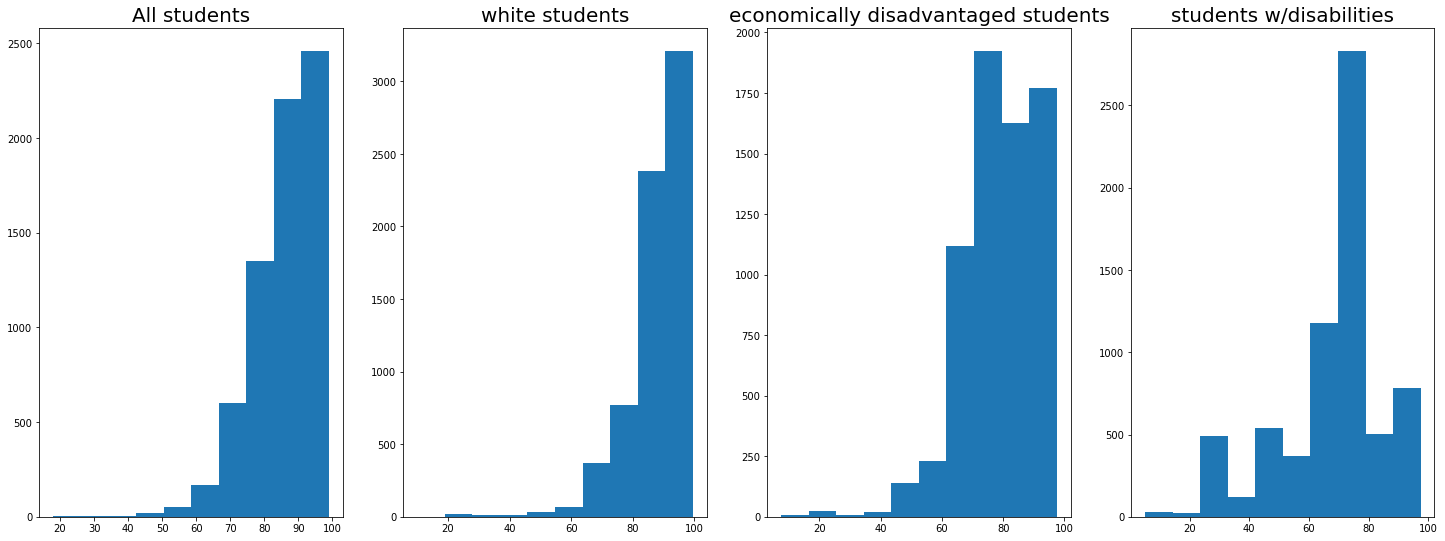

In [252]:
fig, ax = plt.subplots(ncols=4, figsize=(25,9))
ax[0].hist(main_df['ALL_RATE_1112'])
ax[0].set_title('All students', fontdict= {'fontsize':20})

ax[1].hist(main_df['MWH_RATE_1112'])
ax[1].set_title('white students', fontdict= {'fontsize':20})

ax[2].hist(main_df['ECD_RATE_1112'])
ax[2].set_title('economically disadvantaged students', fontdict= {'fontsize':20})

ax[3].hist(main_df['CWD_RATE_1112'])
ax[3].set_title('students w/disabilities', fontdict= {'fontsize':20})

In [253]:
#All plots have left skew. Median graduation rate for both types of disadvantaged students is similar.
#Median graduation rate for white students is much higher at 89%, which is nearly at the 90% graduation goal.

Text(0.5,1,'All vs students w/disabilities')

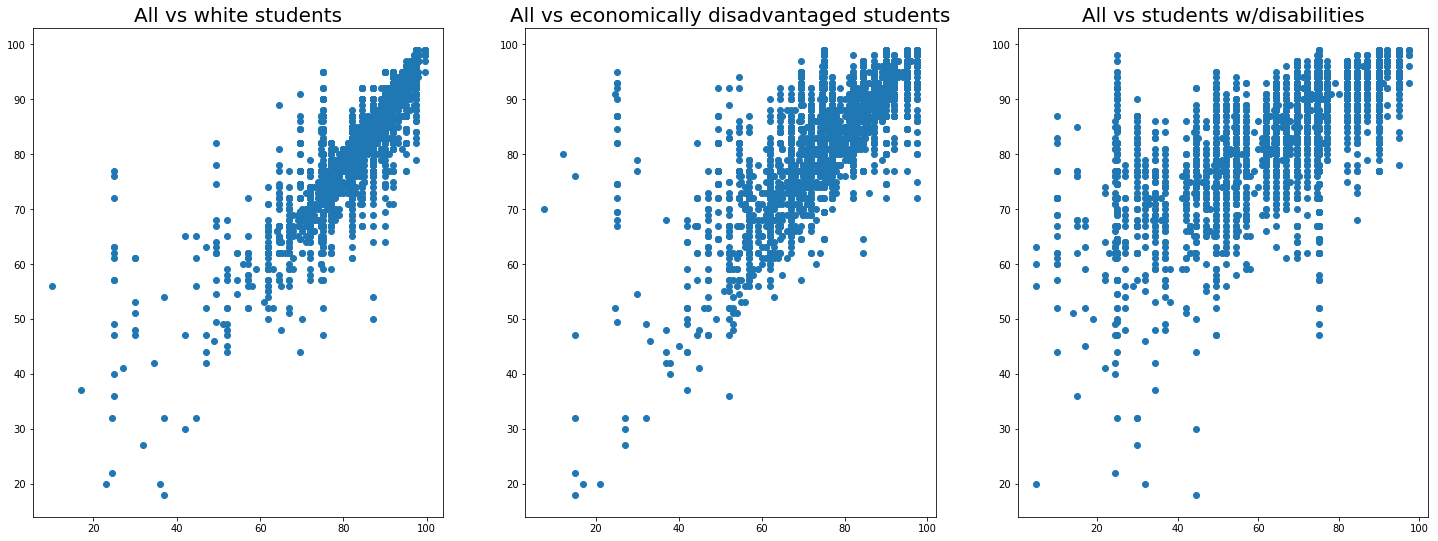

In [254]:
#compare features via scatter
fig, ax = plt.subplots(ncols=3, figsize=(25,9))
ax[0].scatter(x=main_df['MWH_RATE_1112'],y=main_df['ALL_RATE_1112'])
ax[0].set_title('All vs white students', fontdict= {'fontsize':20})

ax[1].scatter(x=main_df['ECD_RATE_1112'], y=main_df['ALL_RATE_1112'])
ax[1].set_title('All vs economically disadvantaged students', fontdict= {'fontsize':20})

ax[2].scatter(x=main_df['CWD_RATE_1112'], y=main_df['ALL_RATE_1112'])
ax[2].set_title('All vs students w/disabilities', fontdict= {'fontsize':20})

In [255]:
#Group by state name, see if specific states are performing better within certain groups or overall
state_groups = main_df.groupby(by='STNAM')

#Looking at graduation rates by state
print(state_groups['ALL_RATE_1112'].median().sort_values(ascending=False).head(15))

#A few states have median high school graduation rates above 90%.
#Lets see how their overall graduation rates compare to specific groups

STNAM
PENNSYLVANIA     92.0
WISCONSIN        92.0
CONNECTICUT      92.0
OHIO             92.0
TEXAS            92.0
TENNESSEE        92.0
INDIANA          91.0
NEBRASKA         90.0
NEW JERSEY       90.0
IOWA             90.0
MISSOURI         90.0
MASSACHUSETTS    90.0
MARYLAND         89.0
KANSAS           88.0
CALIFORNIA       88.0
Name: ALL_RATE_1112, dtype: float64


In [256]:
state_groups['ECD_RATE_1112'].median().sort_values(ascending=False).head(10)

STNAM
MAINE           95.0
TEXAS           90.0
INDIANA         87.0
TENNESSEE       87.0
MISSOURI        84.5
ARKANSAS        84.5
WISCONSIN       84.5
IOWA            84.5
OHIO            84.5
PENNSYLVANIA    84.5
Name: ECD_RATE_1112, dtype: float64

In [257]:
state_groups['MWH_RATE_1112'].median().sort_values(ascending=False).head(10)

STNAM
TEXAS            95.0
MISSOURI         92.0
PENNSYLVANIA     92.0
MASSACHUSETTS    92.0
INDIANA          92.0
WISCONSIN        92.0
NEBRASKA         92.0
NEW JERSEY       92.0
CONNECTICUT      92.0
KANSAS           92.0
Name: MWH_RATE_1112, dtype: float64

In [258]:
state_groups['CWD_RATE_1112'].median().sort_values(ascending=False).head(10)

STNAM
TENNESSEE        77.0
MISSOURI         75.0
PENNSYLVANIA     75.0
WISCONSIN        75.0
MONTANA          75.0
NEBRASKA         75.0
NEW HAMPSHIRE    75.0
NEW JERSEY       75.0
KANSAS           75.0
IOWA             75.0
Name: CWD_RATE_1112, dtype: float64

In [39]:
# #Differences between all rates and group graduation rates. Goal is to find minimum difference between rates

# #Feature creation
# def get_diff_mwh(row):
#     return (row['ALL_RATE_1112'] - row['MWH_RATE_1112']) / row['ALL_COHORT_1112']

# def get_diff_cwd(row):
#     return (row['ALL_RATE_1112'] - row['CWD_RATE_1112']) / row['ALL_COHORT_1112']
    
# def get_diff_ecd(row):
#     return (row['ALL_RATE_1112'] - row['ECD_RATE_1112']) / row['ALL_COHORT_1112']
    
# main_df['mwh_diff'] = main_df.apply(get_diff_mwh, axis=1)
# main_df['cwd_diff'] = main_df.apply(get_diff_cwd, axis=1)
# main_df['ecd_diff'] = main_df.apply(get_diff_ecd, axis=1)

In [40]:
# #Observing sums of differences for each set of rates
# print(main_df['mwh_diff'].sum())
# print(main_df['ecd_diff'].sum())
# print(main_df['cwd_diff'].sum())

# #Another way at looking at difference in graduation rates between groups. Result show the same trend as before

-98.89837517005633
338.646720343833
858.2505029269906


In [41]:
# #Regrouping states
# state_groups = main_df.groupby(by='STNAM')

In [42]:
# state_groups['ecd_diff'].sum().sort_values()

STNAM
MAINE                   -0.272436
DISTRICT OF COLUMBIA    -0.002261
HAWAII                   0.000217
MARYLAND                 0.195587
UTAH                     0.289500
DELAWARE                 0.304215
ARIZONA                  0.465938
ALASKA                   0.518078
NEVADA                   0.702450
NORTH CAROLINA           0.725846
LOUISIANA                0.729930
FLORIDA                  0.893984
WEST VIRGINIA            1.077392
MISSISSIPPI              1.208025
SOUTH CAROLINA           1.285369
NEW MEXICO               1.335958
TENNESSEE                1.444701
RHODE ISLAND             1.780987
CALIFORNIA               2.029561
ALABAMA                  2.763667
COLORADO                 2.919460
MONTANA                  3.039458
SOUTH DAKOTA             3.307121
GEORGIA                  3.416281
VIRGINIA                 3.689280
NORTH DAKOTA             3.935159
VERMONT                  3.940004
INDIANA                  4.331277
WYOMING                  4.552799
NEW HAMP

In [43]:
# state_groups['cwd_diff'].sum().sort_values()

STNAM
HAWAII                    0.001519
DISTRICT OF COLUMBIA      0.004270
ALASKA                    0.552698
MARYLAND                  0.747829
DELAWARE                  0.908926
NEVADA                    1.246685
UTAH                      1.599816
RHODE ISLAND              2.116228
MAINE                     2.941531
ARIZONA                   3.390477
FLORIDA                   3.540659
MONTANA                   3.635263
NEW MEXICO                3.838144
WEST VIRGINIA             3.948605
NORTH DAKOTA              4.246886
SOUTH DAKOTA              4.906768
WYOMING                   5.418089
NORTH CAROLINA            5.866241
COLORADO                  6.017183
TENNESSEE                 6.501988
VERMONT                   6.569186
ALABAMA                   7.773686
NEW HAMPSHIRE             8.063254
SOUTH CAROLINA            8.632402
LOUISIANA                 9.452880
NEW JERSEY                9.686667
MISSISSIPPI               9.913282
CONNECTICUT              10.425525
NEBRASKA      

In [ ]:
#Sum results of percentage differences do not seem to be entirely consistent with the aggregate graduation rates for states
#I likely should recalculate percentages on the state level based on cohort sizes for better accuracy


### Transforming Target to Classes

In [259]:
main_df['ALL_RATE_1112'].describe()

count    6874.000000
mean       85.494690
std         9.127833
min        18.000000
25%        82.000000
50%        87.000000
75%        92.000000
max        99.000000
Name: ALL_RATE_1112, dtype: float64

In [260]:
#Make splits along quartiles
def to_categorical(target):
    if target <= 82.0:
        return 1
    elif (target <= 87.0):
        return 2
    elif (target <= 92.0):
        return 3
    else:
        return 4

In [261]:
main_df['target'] = main_df['ALL_RATE_1112'].map(to_categorical)

target = main_df['target']
all_rate = main_df['ALL_RATE_1112']
main_df.drop(['target', 'ALL_RATE_1112'], axis=1, inplace=True)

In [262]:
#make dummy variables
main_wd = pd.get_dummies(main_df)

In [263]:
#Look for features with negative minimums
mask_negatives = (main_wd.min() < 0)

columns_w_negatives = main_wd.min()[mask_negatives.values].index

for col in columns_w_negatives:
    main_wd[col] = main_wd[col].map(lambda x: 0 if x < 0 else x)

### Modeling

In [264]:
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [267]:
#Train test split for regression modeling
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(main_wd, all_rate, random_state=3)

In [68]:
#Gridsearched elastic net parameters for good hyperparameters. Used these to fit a model from which to extract
#coefficients for measure of significance.

# #Pipeline
# ss = StandardScaler()
# enet = ElasticNet()

# pipe = Pipeline([
#     ('ss', ss),
#     ('enet', enet)
# ])

# #Gridsearch on enet model
# params = {
#     'enet__alpha': [0.1, .5, .9],
#     'enet__l1_ratio': [0, 0.2, 0.8, 1]
# }

# gs_enet = GridSearchCV(pipe, param_grid=params)
# gs_enet.fit(X_train_r, y_train_r)
# print(gs_enet.best_score_)
# print(gs_enet.score(X_test, y_test))
# gs_enet.best_params_

/Users/agalan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/agalan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/agalan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/agalan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

0.8641635966286558
-5635.813765138933


{'enet__alpha': 0.1, 'enet__l1_ratio': 0.8}

In [269]:
#Elastic net model
ss = StandardScaler()
enet = ElasticNet(alpha=0.1, l1_ratio=0.8)

ss.fit(X_train_r)
X_sc_train = ss.transform(X_train_r)
X_sc_test = ss.transform(X_test_r)

enet.fit(X_sc_train, y_train_r)
print(enet.score(X_sc_train, y_train_r))
print(enet.score(X_sc_test, y_test_r))

0.9222915370007498
0.8565843573462677


In [270]:
#Will use coefficient array after CART modeling as a point of comparison
enet.coef_

array([ 0.02227181,  0.0202136 , -0.        , ..., -0.        ,
        0.        , -0.        ])

### Cart Modeling

In [271]:
#Train test split again with categorical target
X_train, X_test, y_train, y_test = train_test_split(main_wd, target, stratify=target, random_state=3)

In [114]:
#Baseline decision tree model without any tuning as baseline model

# dt = DecisionTreeClassifier()
# dt_param_grid = {}

# gs = GridSearchCV(dt, param_grid=dt_param_grid)
# gs.fit(X_train, y_train)
# print(gs.best_score)
# print gs.score(X_test, y_test)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
#NOTE: Selected 46 features with RFE and compared gridsearched decisiontree, randomforest, bagging, 
#adaboost, and gradientboost models. Gradient boost scored the best on my test set.

#For all of the following gridsearched models, I have replaced param grid with the selected best features to improve
#train time.

In [272]:
#best performing model of those passed 46 features

gb = GradientBoostingClassifier()
gb_params = {
    'max_depth': [3],
    'min_samples_split': [3],
    'n_estimators': [75],
    'max_features': ['auto']
}
gs_gb = GridSearchCV(gb, gb_params)
gs_gb.fit(X_reduced_train, y_train)
print('parameters: ', gs_gb.best_params_)
print('train score: ', gs_gb.best_score_)
print('test score: ', gs_gb.score(X_reduced_test, y_test))

parameters:  {'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 3, 'n_estimators': 75}
train score:  0.8102812803103783
test score:  0.8173356602675974


In [273]:
#Gradient boosting model with 16 features. Some improvement on scores.

selector = RFE(DecisionTreeClassifier(), n_features_to_select=16, step=.1)
selector.fit(X_train, y_train)

mask = selector.support_
selected_features = main_wd.columns[mask]

X_reduced_train = selector.transform(X_train)
X_reduced_test = selector.transform(X_test)

#Remodeling with 16 features
gb = GradientBoostingClassifier()
gb_params = {
    'max_depth': [3],
    'min_samples_split': [2],
    'n_estimators': [125],
    'max_features': ['auto']
}

gs_gb = GridSearchCV(gb, gb_params)
gs_gb.fit(X_reduced_train, y_train)
print('parameters: ', gs_gb.best_params_)
print('train score: ', gs_gb.best_score_)
print('test score: ', gs_gb.score(X_reduced_test, y_test))

parameters:  {'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 125}
train score:  0.8401551891367605
test score:  0.847585805700989


In [274]:
#array of feature importances
gb_importance = gs_gb.best_estimator_.feature_importances_

#Dataframe of included features with their corresponding importances
feature_importances_df = pd.DataFrame(data={'features': selected_features, 'importance': gb_importance})
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

In [275]:
#Comparison of feature selection between kbest and RFE.

k_best = SelectKBest(k=16).fit(X_train, y_train)
X_reduced_train = k_best.transform(X_train)
X_reduced_test = k_best.transform(X_test)
mask = selector.get_support()
k_best_features = main_wd.columns[mask]

#16 features using kbest
gb_k = GradientBoostingClassifier()
gb_k_params = {
    'max_depth': [3],
    'min_samples_split': [3],
    'n_estimators': [75],
    'max_features': ['auto']
}

gs_gb_k = GridSearchCV(gb_k, gb_k_params)
gs_gb_k.fit(X_reduced_train, y_train)
print('parameters: ', gs_gb_k.best_params_)
print('train score: ', gs_gb_k.best_score_)
print('test score: ', gs_gb_k.score(X_reduced_test, y_test))

/Users/agalan/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  405   443   445 ... 35798 35799 35802] are constant.
  UserWarning)
/Users/agalan/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


parameters:  {'max_depth': 3, 'max_features': 'auto', 'min_samples_split': 3, 'n_estimators': 75}
train score:  0.8098933074684772
test score:  0.8173356602675974


In [276]:
#Dataframe of kbest selected features with corresponding feature importances

gb_importance = gs_gb_k.best_estimator_.feature_importances_

feature_importances_k = pd.DataFrame(data={'features': selected_features, 'importance': gb_importance})
feature_importances_k = feature_importances_k.sort_values(by='importance', ascending=False)

### Comparing Results of Modeling and Data Exploration

In [277]:
#Feature importances from 16 feature gradient boosting model
feature_importances_df

,features,importance
2,MWH_RATE_1112,0.205378
1,MWH_COHORT_1112,0.098579
5,ECD_RATE_1112,0.093550
0,ALL_COHORT_1112,0.084010
15,employee_benefits_spending,0.064185
8,pct_NH_White_alone_CEN_2010,0.062119
4,ECD_COHORT_1112,0.061247
6,Hispanic_CEN_2010,0.047908
10,fed_titleI_rev,0.043620
7,Med_House_value_ACS_08_12,0.042835


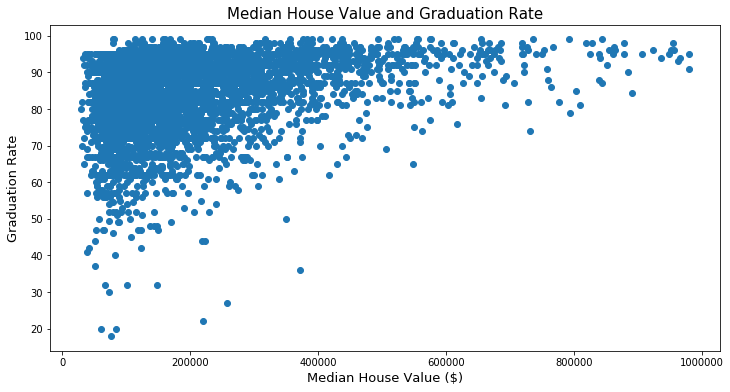

In [322]:
#Looked at scatter plots for important features and all_rate.
#Did not see distinct patterns with the exception of Med_House_value_ACS_08_12

plt.figure(figsize=(12,6))
plt.scatter(main_df['Med_House_value_ACS_08_12'], all_rate)
plt.title("Median House Value and Graduation Rate", fontsize=15);
plt.xlabel("Median House Value ($)", fontsize=13);
plt.ylabel("Graduation Rate", fontsize=13);

In [ ]:
# Median house price positively correlates with graduation rate

In [279]:
#Dataframe of features and their coefficients from linear regression model
coefficients_df = pd.DataFrame({'features': main_wd.columns, 'coefficients': enet.coef_})
coefficients_df['abs_coef'] = coefficients_df["coefficients"].map(lambda x: abs(x))

#top 16 coefficients by absolute value 
top_16_coefs = coefficients_df.sort_values(by="abs_coef", ascending=False).head(16)
top_16_coefs

,coefficients,features,abs_coef
4,5.439528,MWH_RATE_1112,5.439528
8,2.163300,ECD_RATE_1112,2.163300
6,0.882348,CWD_RATE_1112,0.882348
376,-0.345889,fed_titleI_rev_p,0.345889
365,-0.267374,SCHEXPCSSGA,0.267374
379,0.243972,local_rev_tot_p,0.243972
375,-0.229164,fed_rev_tot_p,0.229164
47,0.174895,NH_White_alone_CEN_2010,0.174895
51,-0.149843,NH_AIAN_alone_CEN_2010,0.149843
382,0.147137,local_rev_charges_p,0.147137


In [280]:
#Features overlapping between gradient boosted model and highest weighted linear regression features
overlapping_features = [feature for feature in top_16_coefs['features'].values if feature in feature_importances_df['features'].values]
overlapping_features

['MWH_RATE_1112',
 'ECD_RATE_1112',
 'CWD_RATE_1112',
 'pct_NH_White_alone_CEN_2010']

In [281]:
top_16_coefs
#overlapping features coefficient fed_titleI_rev is negatively correlated with the target,
#the rest are positively correlated

#fed_titleI_rev is a feature indicating federal title I revenue. Title I is a funding program for schools with high
#percentages of low income families

,coefficients,features,abs_coef
4,5.439528,MWH_RATE_1112,5.439528
8,2.163300,ECD_RATE_1112,2.163300
6,0.882348,CWD_RATE_1112,0.882348
376,-0.345889,fed_titleI_rev_p,0.345889
365,-0.267374,SCHEXPCSSGA,0.267374
379,0.243972,local_rev_tot_p,0.243972
375,-0.229164,fed_rev_tot_p,0.229164
47,0.174895,NH_White_alone_CEN_2010,0.174895
51,-0.149843,NH_AIAN_alone_CEN_2010,0.149843
382,0.147137,local_rev_charges_p,0.147137


In [ ]:
#Negative coefficient of titleI_rev_p indicates that lower income areas have worse graduation rates

#Positive coefficient of the percentage of the ACS population aged 25 years and over that have a college
#degree or higher(pct_College_ACS_08_12) suggests that high school students living in communities with more college graduates
#are more likely to graduate highschool.

# The positive coefficient of percentage of revenue from local sources compared with the negative coefficient
#of percentage of revenue from federal sources suggests that local allocation of money is more effective than federal.
#Perhaps the reason being local agencies are better informed on using resources. The difference could also simply indicate
#differences between federal and local funding. On average, local funding is an order of magnitude higher than federal funding.
#Thus, a district with a high percentage of federal funding could simply have less funding.

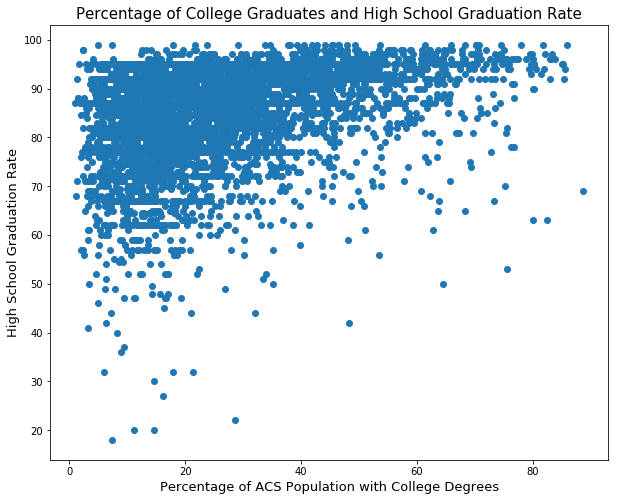

In [329]:
#Scatter of percentage of college graduates and high school graduation rate
plt.figure(figsize = (10,8))
plt.scatter(main_df['pct_College_ACS_08_12'], all_rate)
plt.title("Percentage of College Graduates and High School Graduation Rate", fontsize=15);
plt.xlabel("Percentage of ACS Population with College Degrees", fontsize=13);
plt.ylabel("High School Graduation Rate", fontsize=13);

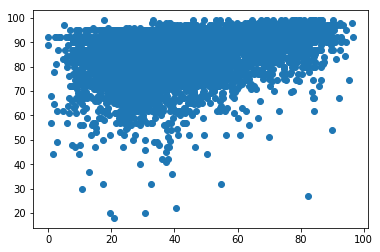

In [344]:
plt.scatter(main_df['local_rev_tot_p'], all_rate)
#plt.xlim(-100000,1000000)

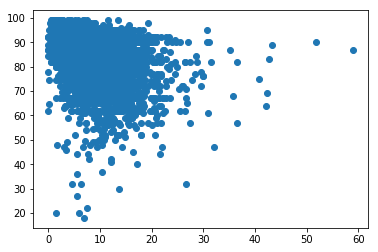

In [345]:
plt.scatter(main_df['fed_rev_tot_p'], all_rate)
#plt.xlim(-10000,200000)

In [353]:
#Comparing shape of federal revenue and local revenue
main_df[['fed_rev_tot', 'local_revenue_total']].describe()

,fed_rev_tot,local_revenue_total
count,6.874000e+03,6.874000e+03
mean,5.549924e+03,3.004113e+04
std,2.320987e+04,8.423638e+04
min,0.000000e+00,0.000000e+00
25%,7.790000e+02,4.787500e+03
50%,1.625000e+03,1.092950e+04
75%,3.904500e+03,2.889450e+04
max,1.091741e+06,2.484531e+06
